In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [27]:
#Read dataset
df = pd.read_csv(r"D:\data\DoS_dataset.csv")

In [28]:
df

,Unnamed: 0,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Label
0,0,1.478198e+09,790,8,5,33,104,9,33,33,0,111,0
1,1,1.478198e+09,399,8,254,91,0,0,0,60,0,0,0
2,2,1.478198e+09,608,8,25,33,34,48,8,142,109,58,0
3,3,1.478198e+09,672,8,100,0,154,29,151,2,189,0,0
4,4,1.478198e+09,809,8,64,187,127,20,17,32,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1048570,1.478199e+09,0,8,0,0,0,0,0,0,0,0,1
1048571,1048571,1.478199e+09,608,8,27,35,35,48,8,142,110,1,0
1048572,1048572,1.478199e+09,0,8,0,0,0,0,0,0,0,0,1
1048573,1048573,1.478199e+09,672,8,4,0,154,29,151,2,189,0,0


In [29]:
df.Label.value_counts()

0    815571
1    233004
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [30]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [31]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [22]:
df.Label.value_counts()

0    3347013
1     491847
Name: Label, dtype: int64

In [32]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [34]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [35]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [36]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [14]:
df_major['klabel'].value_counts()

84     3546
828    2563
104    2421
103    2354
734    2338
       ... 
426     136
945     127
722     123
783     114
763      63
Name: klabel, Length: 1000, dtype: int64

In [15]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [16]:
df_major

,Unnamed: 0,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,klabel,Label
0,-1.732048,-1.724077,0.554054,0.087416,-0.486045,-0.032770,1.470088,-0.475482,-0.043584,-0.251144,-0.396702,1.113437,47,0
1,-1.732045,-1.724076,-0.331029,0.087416,2.419281,1.102293,-0.544168,-0.579693,-0.542830,0.106914,-0.396702,-0.572592,455,0
2,-1.732042,-1.724075,0.142072,0.087416,-0.252686,-0.032770,0.114339,-0.023903,-0.421801,1.194348,1.751034,0.308396,524,0
3,-1.732038,-1.724074,0.286945,0.087416,0.622413,-0.678582,2.438481,-0.243903,1.741597,-0.662247,3.327353,-0.572592,211,0
4,-1.732035,-1.724073,0.597064,0.087416,0.202365,2.981018,1.915549,-0.348114,-0.285643,-0.264405,-0.396702,-0.268803,383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,1.732009,1.701986,0.359381,0.087416,-0.311026,-0.678582,-0.544168,-0.579693,-0.542830,-0.688770,-0.396702,-0.572592,859,0
1048567,1.732025,1.701992,0.554054,0.087416,-0.486045,0.006370,1.392617,-0.475482,-0.013327,-0.237882,-0.396702,1.098247,734,0
1048569,1.732032,1.701994,-0.331029,0.087416,2.419281,1.082723,-0.544168,-0.579693,-0.542830,0.106914,-0.396702,-0.572592,963,0
1048571,1.732038,1.701996,0.142072,0.087416,-0.229350,0.006370,0.133707,-0.023903,-0.421801,1.194348,1.770738,-0.557402,140,0


In [17]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [18]:
result['Label'].value_counts()

0    6508
Name: Label, dtype: int64

In [19]:
result

,Unnamed: 0,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,klabel,Label
137868,-1.276584,-1.319030,0.685346,0.087416,-0.486045,-0.052340,0.462960,0.624518,1.227223,-0.688770,-0.396702,-0.390318,0,0
143049,-1.259468,-1.307968,0.685346,0.087416,-0.486045,-0.052340,0.462960,0.624518,1.227223,-0.688770,-0.396702,-0.390318,0,0
146432,-1.248292,-1.298789,0.685346,0.087416,-0.486045,-0.052340,0.153075,0.624518,1.242351,-0.688770,-0.396702,-0.101719,0,0
182564,-1.128925,-1.199206,0.685346,0.087416,-0.486045,-0.052340,0.462960,0.624518,1.257480,-0.688770,-0.396702,-0.359939,0,0
154413,-1.221925,-1.281542,0.685346,0.087416,-0.486045,-0.052340,0.462960,0.624518,1.242351,-0.688770,-0.396702,-0.344750,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009223,1.602047,1.568392,-0.509857,0.087416,-0.544385,-0.678582,-0.544168,-0.579693,-0.452058,-0.264405,0.391458,-0.253613,999,0
995852,1.557875,1.514484,-0.509857,0.087416,-0.544385,-0.678582,-0.544168,-0.579693,-0.270514,-0.198098,0.489978,-0.527023,999,0
946359,1.394368,1.371682,-0.509857,0.087416,-0.544385,-0.678582,-0.544168,-0.579693,-0.512573,-0.436803,0.391458,-0.481455,999,0
947163,1.397024,1.373756,-0.509857,0.087416,-0.544385,-0.678582,-0.544168,-0.579693,-0.452058,-0.251144,0.509682,-0.223234,999,0


In [20]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [21]:
result.to_csv("D:\data\sample_km.csv",index=0)

### split train set and test set

In [22]:
# Read the sampled dataset
df=pd.read_csv("D:\data\sample_km.csv")

In [23]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 42, stratify = y)

## Feature engineering

### Feature selection by information gain

In [25]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [26]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [27]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [28]:
X_fs = df[fs].values

In [29]:
X_fs.shape

(239512, 10)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [30]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [31]:
X_fss = fcbf.fit_transform(X_fs,y)

In [32]:
X_fss.shape

(239512, 10)

### Re-split train & test sets after feature selection

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 42,stratify = y)

In [34]:
X_train.shape

(191609, 10)

In [35]:
pd.Series(y_train).value_counts()

1    186403
0      5206
dtype: int64

### SMOTE to solve class-imbalance

In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(n_jobs=-1, sampling_strategy={0: 90000, 1: 186403})

In [37]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
pd.Series(y_train).value_counts()

1    186403
0     90000
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

[13:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



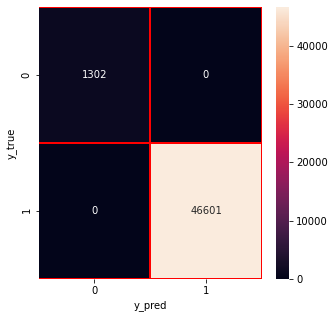

In [39]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [40]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

[13:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
Average inference time per sample: 0.000152 ms
Model size: 34.73 KB
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



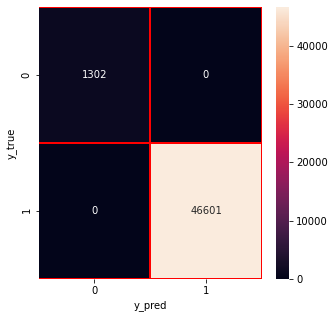

In [41]:
import time
import os
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# ================= 模型训练 =================
xg = xgb.XGBClassifier(
    learning_rate=0.7340229699980686,
    n_estimators=70,
    max_depth=14,
    use_label_encoder=False,
    eval_metric='logloss'
)

xg.fit(X_train, y_train)

# ================= 推理时间统计 =================
start_time = time.perf_counter()
y_predict = xg.predict(X_test)
end_time = time.perf_counter()

total_test_time = end_time - start_time
avg_time_per_sample = total_test_time / X_test.shape[0]

# ================= 模型大小统计（KB） =================
model_path = "xgboost_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xg, f)

model_size_kb = os.path.getsize(model_path) / 1024  # KB

# ================= 性能指标 =================
xg_score = xg.score(X_test, y_test)
y_true = y_test

precision, recall, fscore, _ = precision_recall_fscore_support(
    y_true, y_predict, average='weighted'
)

print('Accuracy of XGBoost:', xg_score)
print('Precision of XGBoost:', precision)
print('Recall of XGBoost:', recall)
print('F1-score of XGBoost:', fscore)

print('Average inference time per sample: {:.6f} ms'.format(
    avg_time_per_sample * 1000
))
print('Model size: {:.2f} KB'.format(model_size_kb))

print(classification_report(y_true, y_predict))

# ================= 混淆矩阵 =================
cm = confusion_matrix(y_true, y_predict)

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    linewidth=0.5,
    linecolor="red",
    fmt=".0f",
    ax=ax
)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [43]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



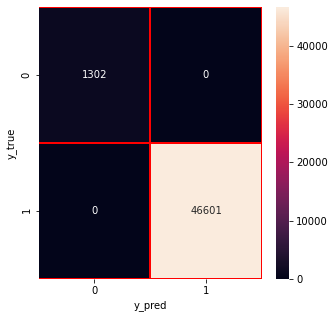

In [44]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [45]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
n_features = X_train.shape[1]

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'max_features': hp.quniform('max_features', 1, n_features, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}


best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 10/10 [01:58<00:00, 11.88s/trial, best loss: -1.0]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 29.0, 'max_features': 4.0, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0, 'n_estimators': 50.0}


X_train shape: (276403, 10)
Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



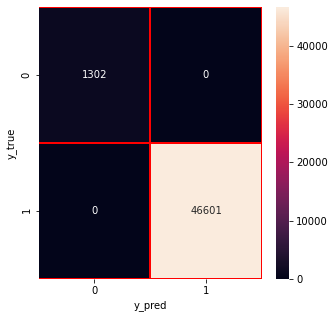

In [46]:
# 检查特征数量
print(f"X_train shape: {X_train.shape}")
n_features = X_train.shape[1]

# 使用不超过特征数量的值
rf_hpo = RandomForestClassifier(
    n_estimators=71, 
    min_samples_leaf=1, 
    max_depth=46, 
    min_samples_split=9, 
    max_features=min(10, n_features),  # 不能超过特征数量
    criterion='entropy',
    n_jobs=-1,  # 使用所有CPU核心
    random_state=42  # 确保可重复性
)

rf_hpo.fit(X_train, y_train)
rf_score = rf_hpo.score(X_test, y_test)

y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 1.0
Precision of DT: 1.0
Recall of DT: 1.0
F1-score of DT: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



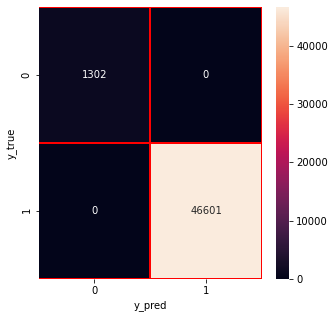

In [48]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [49]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# 获取特征数量
n_features = X_train.shape[1]
print(f"Number of features: {n_features}")

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split": int(params['min_samples_split']),
        "min_samples_leaf": int(params['min_samples_leaf']),
        "criterion": str(params['criterion'])
    }
    
    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features": hp.quniform('max_features', 1, n_features, 1),  # 改为 n_features
    "min_samples_split": hp.quniform('min_samples_split', 2, 11, 1),
    "min_samples_leaf": hp.quniform('min_samples_leaf', 1, 11, 1),
    "criterion": hp.choice('criterion', ['gini', 'entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

print("Decision tree: Hyperopt estimated optimum {}".format(best))

Number of features: 10
100%|██████████| 50/50 [00:09<00:00,  5.55trial/s, best loss: -1.0]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 44.0, 'max_features': 6.0, 'min_samples_leaf': 6.0, 'min_samples_split': 7.0}


Accuracy of DT: 1.0
Precision of DT: 1.0
Recall of DT: 1.0
F1-score of DT: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



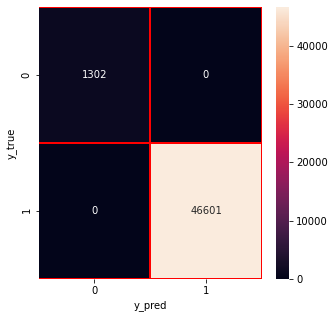

In [50]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 10, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [51]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



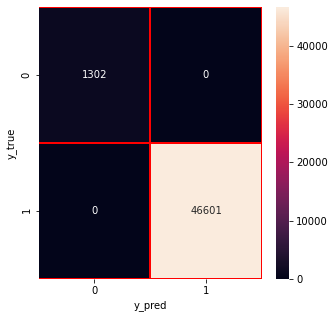

In [52]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [54]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 10, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [04:12<00:00, 12.64s/trial, best loss: -1.0]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 28.0, 'max_features': 5.0, 'min_samples_leaf': 4.0, 'min_samples_split': 9.0, 'n_estimators': 141.0}


Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



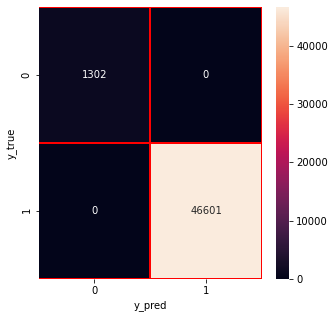

In [56]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 10, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [57]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [58]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [59]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [60]:
dt_train.shape

(276403, 1)

In [61]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

[13:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



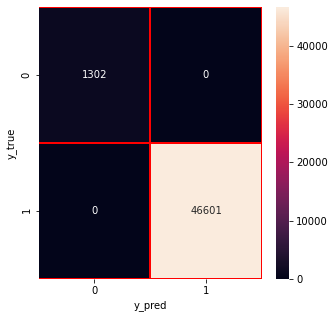

In [62]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [63]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

[13:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1302
           1       1.00      1.00      1.00     46601

    accuracy                           1.00     47903
   macro avg       1.00      1.00      1.00     47903
weighted avg       1.00      1.00      1.00     47903



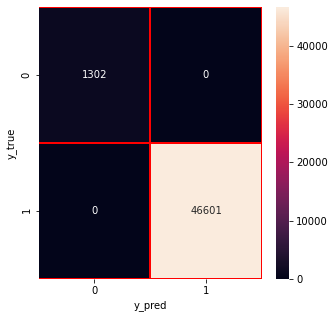

In [64]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [66]:
df=pd.read_csv(r"D:\data\DoS_dataset.csv")

In [67]:
df.Label.value_counts()

0    815571
1    233004
Name: Label, dtype: int64

In [75]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('D:\data\CHDdadaset_sample_km_without_portscan.csv',index=0)

In [76]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
result.to_csv("D:\data\CHDdadaset_sample_km_portscan.csv",index=0)

### Read the generated datasets for unknown attack detection

In [77]:
df1 = pd.read_csv('D:\data\CHDdadaset_sample_km_without_portscan.csv')
df2 = pd.read_csv('D:\data\CHDdadaset_sample_km_portscan.csv')

In [78]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [79]:
df1.Label.value_counts()

0    815571
1    233004
Name: Label, dtype: int64

In [80]:
df2.Label.value_counts()

1    233004
0      6508
Name: Label, dtype: int64

In [81]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [82]:
df2.Label.value_counts()

1    233004
0     62669
Name: Label, dtype: int64

In [83]:
df = df1.append(df2)

In [84]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    878240
1    466008
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [85]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [86]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [87]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [88]:
X_fs = df[fs].values

In [89]:
X_fs.shape

(1344248, 10)

In [90]:
X_fs

array([[ 0.55405449, -0.25114376, -0.48604524, ...,  1.47008835,
        -0.3967017 , -1.7240767 ],
       [-0.3310292 ,  0.10691376,  2.41928093, ..., -0.544168  ,
        -0.3967017 , -1.7240759 ],
       [ 0.1420718 ,  1.19434771, -0.2526857 , ...,  0.11433888,
         1.75103383, -1.72407502],
       ...,
       [ 1.2263559 ,  1.24739327, -0.54438512, ...,  1.31514555,
        -0.21936574, -0.06378044],
       [ 1.48441099, -0.68876962, -0.06599808, ...,  0.21117813,
        -0.3967017 ,  1.1322268 ],
       [ 1.22861955,  1.97676971,  2.43094891, ..., -0.544168  ,
        -0.23906974, -0.21805627]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 3)
#fcbf.fit(X_fs, y)

In [122]:
# X_fss = fcbf.fit_transform(X_fs,y)
# 基于树模型的特征重要性选择
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_fs, y)
importances = rf.feature_importances_
top_k_indices = np.argsort(importances)[-10:]
X_fss = X_fs[:, top_k_indices]

In [123]:
X_fss.shape

(1344248, 10)

In [124]:
X_fss

array([[-1.7240767 ,  1.47008835, -0.04358441, ..., -0.25114376,
        -0.03277024,  0.55405449],
       [-1.7240759 , -0.544168  , -0.54283011, ...,  0.10691376,
         1.10229284, -0.3310292 ],
       [-1.72407502,  0.11433888, -0.42180085, ...,  1.19434771,
        -0.03277024,  0.1420718 ],
       ...,
       [-0.06378044,  1.31514555,  1.36338074, ...,  1.24739327,
         0.57390141,  1.2263559 ],
       [ 1.1322268 ,  0.21117813, -0.54283011, ..., -0.68876962,
         0.08465008,  1.48441099],
       [-0.21805627, -0.544168  ,  3.31497756, ...,  1.97676971,
        -0.678582  ,  1.22861955]])

####  kernel principal component analysis (KPCA)

In [ ]:

from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

nystroem = Nystroem(kernel='rbf', gamma=0.1, n_components=500, random_state=42)

X_map = nystroem.fit_transform(X_fss)
pca = PCA(n_components=10)
X_kpca = pca.fit_transform(X_map)


# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components = 10, kernel = 'rbf')
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [109]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [110]:
pd.Series(y_train).value_counts()

0    815571
1    233004
dtype: int64

In [118]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:40000})
X_train, y_train = smote.fit_resample(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [67212, 1048575]

In [113]:
pd.Series(y_train).value_counts()

0    815571
1    233004
dtype: int64

In [114]:
pd.Series(y_test).value_counts()

1    233004
0     62669
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [115]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [116]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [117]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required.

### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.6972111553784861
43 0.7127490039840637
43 0.399203187250996
43 0.47051792828685257
32 0.653784860557769
20 0.34860557768924305
16 0.9195219123505977
5 0.4370517928286853
15 0.6729083665338645
25 0.7063745019920319
2 0.47808764940239046
50 0.4199203187250996


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.39282868525896414
17 0.42828685258964144


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2 0.47768924302788845


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.6992031872509961


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


16 0.3737051792828685


C:\Program Files\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


50 0.6250996015936255
9.127083539962769
Best score=0.9195
Best parameters: n_clusters=16


In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

23 0.34422310756972113
15 0.6685258964143427
46 0.450199203187251
15 0.4896414342629482
29 0.6824701195219124
36 0.3888446215139442
22 0.35776892430278884
25 0.34860557768924305
42 0.41832669322709165
27 0.47051792828685257
26 0.39402390438247015
25 0.6824701195219124
33 0.3848605577689243
19 0.7191235059760956
6 0.5824701195219123
21 0.6697211155378486
24 0.451394422310757
37 0.4681274900398406
14 0.47250996015936253
21 0.8434262948207172
100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: 0.15657370517928282]
Random Forest: Hyperopt estimated optimum {'n_clusters': 21.0}


In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1255
           1       0.91      0.99      0.95      1255

    accuracy                           0.95      2510
   macro avg       0.95      0.95      0.94      2510
weighted avg       0.95      0.95      0.94      2510

0.9450199203187251
[[1127  128]
 [  10 1245]]


### Apply the CL-k-means model with biased classifiers

In [ ]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)